In [1]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib
import os
from collections import Counter
import data
import encoder
import train_encoder
from transformers import BertTokenizerFast
import embedding

In [2]:
with open("../data/raw_text.pkl", "rb") as file:
    rawdata = pickle.load(file)

In [3]:
del rawdata['dialogue1']
del rawdata['dialogue2']
del rawdata['dialogue3']
del rawdata['dialogue4']
del rawdata['dialogue5']
del rawdata['dialogue6']
del rawdata['myfirstdaywiththeyankees']
del rawdata['onlyonewaytofindout']

In [4]:
full_stories = list(rawdata.keys())
train_stories, test_stories = train_test_split(full_stories, test_size = 0.3, random_state = 1)

print(len(train_stories))
print(len(test_stories))

model_train_stories, model_eval_stories = train_test_split(train_stories, test_size = 0.3, random_state = 1)

print(len(model_train_stories))
print(len(model_eval_stories))

70
31
49
21


In [5]:
train_sentences = data.split_based_on_flags(rawdata, model_train_stories, 0.7, 30, 100)
eval_sentences = data.split_based_on_flags(rawdata, model_eval_stories, 0.7, 30, 100)

In [6]:
train_sentences[0]

['',
 'well',
 "i'm",
 'in',
 'uh',
 'bergen',
 'belsen',
 'concentration',
 'camp',
 'i',
 "don't",
 'even',
 'know',
 'what',
 'concentration',
 'camp',
 'is',
 "i'm",
 'only',
 'nine',
 'year',
 'old',
 'and',
 'i',
 'see',
 'barbed',
 'wire',
 'around',
 'me',
 'and',
 'uh',
 'watchtower']

In [7]:
eval_sentences[0]

['',
 "i'm",
 'from',
 'a',
 'very',
 'small',
 'african',
 'country',
 'called',
 'zimbabwe',
 "it's",
 'a',
 'country',
 "that's",
 'been',
 'in',
 'the',
 'news',
 'very',
 'recently',
 'for',
 'very',
 'many',
 'bad',
 'reasons',
 'the',
 'one',
 'thing',
 'you',
 'might',
 'not',
 'know',
 'about',
 'zimbabwe',
 'is',
 'that',
 "it's",
 'one',
 'of',
 'the']

In [8]:
train_data = data.load_data(train_sentences)
eval_data = data.load_data(eval_sentences)

length of batch:  1139
Sample 0:
  Text: [CLS] but i was always too scared to google would be to know one way or another i ' m reminded of that great line from all the king ' s men the end of man is knowledge [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
  Attention mask: [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Epoch 1/3: 100%|██████████| 1139/1139 [00:13<00:00, 81.85it/s, loss=7.26]


Epoch 1/3, Train Loss: 7.2392, Val Loss: 6.8993


Epoch 2/3: 100%|██████████| 1139/1139 [00:13<00:00, 87.22it/s, loss=6.67]


Epoch 2/3, Train Loss: 6.6434, Val Loss: 6.9211


Epoch 3/3: 100%|██████████| 1139/1139 [00:13<00:00, 87.34it/s, loss=6.27]


Epoch 3/3, Train Loss: 6.2473, Val Loss: 7.0974
Loss curves saved as bert_loss_curves.png


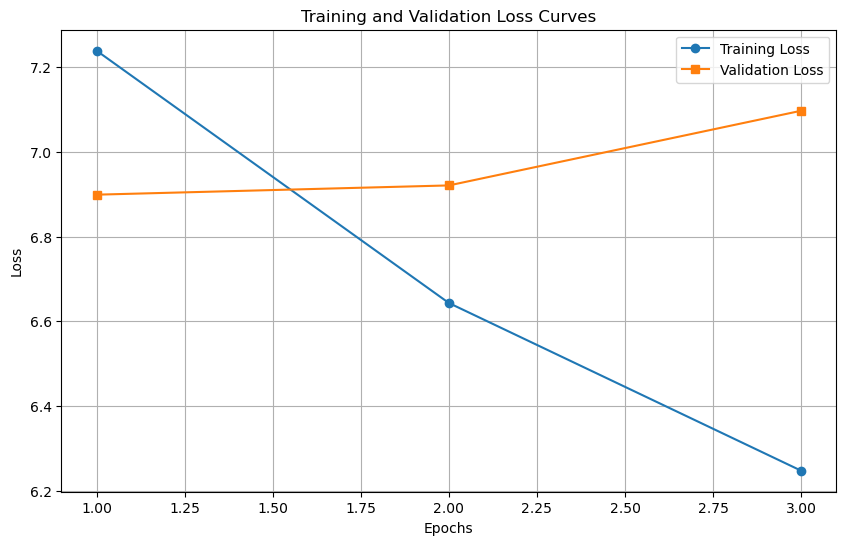

In [10]:
# Code used to demonstrate Encoder model. Note: This is not used for hyperparameter tuning or generating final encoder model. It is simply used for demonstration. 
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
vocab_size = len(tokenizer)

model_bert = encoder.Encoder(vocab_size = vocab_size, hidden_size = 512, num_heads = 4, 
                            num_layers = 2, intermediate_size = 2048, max_len = 128)

model, train_losses, val_losses = train_encoder.train_bert(model = model_bert, 
                                         train_dataloader=train_data,
                                         val_dataloader=eval_data,
                                         tokenizer=tokenizer,
                                         epochs = 3, lr = 5e-4, 
                                         mask_prob = 0.15, device = 'cuda')

In [ ]:
# Hyperparameter Tuning Code. 
# Note that train_data and eval_data referenced in this code are a split from the "training set". 
# There still exists a "test" set that will be used to evaluate our finalized encoder after hyperparameters are tuned.  
"""
!pip install optuna
import optuna
from encoder import Encoder
from train_encoder import train_bert, evaluate_model

model_bert = encoder.Encoder(vocab_size = vocab_size, hidden_size = 256, num_heads = 4, 
                            num_layers = 4, intermediate_size = 512, max_len = 128)


def objective(trial):
    hidden_size = trial.suggest_categorical("hidden_size", [128, 256, 512])
    num_heads = trial.suggest_categorical("num_heads", [4])
    num_layers = trial.suggest_int("num_layers", 2, 6)
    intermediate_size = hidden_size * 4
    dropout = trial.suggest_float("dropout", 0.1, 0.3)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-5)

    model, train_losses, val_losses = train_encoder.train_bert(model = model_bert, 
                                         train_dataloader=train_data,
                                         val_dataloader=eval_data,
                                         tokenizer=tokenizer,
                                         epochs = 10, lr = 5e-4, 
                                         mask_prob = 0.15, device = 'cuda')

    final_val_loss = val_losses[-1]
    return final_val_loss



tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
vocab_size = len(tokenizer)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)
"""

length of batch:  1651
Sample 0:
  Text: [CLS] as opposed to fields which denoted land used to grow plants for human consumption but by the eighteenth century in england ornamental lawns similar to the ones we know now had emerged back then lawns were maintained by scythes and shears making them extraordinarily labor intensive to maintain a lawn without the help of grazing animals was a sign that you were rich enough to hire lots of gardeners and also to own land that did nothing but look pretty [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
  Attention mask: [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

Epoch 1/12: 100%|██████████| 1651/1651 [00:19<00:00, 85.60it/s, loss=7.5] 


Epoch 1/12, Train Loss: 7.4751, Val Loss: 6.5409


Epoch 2/12: 100%|██████████| 1651/1651 [00:19<00:00, 85.90it/s, loss=6.52]


Epoch 2/12, Train Loss: 6.5128, Val Loss: 6.3259


Epoch 3/12: 100%|██████████| 1651/1651 [00:19<00:00, 86.03it/s, loss=6.23]


Epoch 3/12, Train Loss: 6.2194, Val Loss: 6.2038


Epoch 4/12: 100%|██████████| 1651/1651 [00:19<00:00, 86.07it/s, loss=6.05]


Epoch 4/12, Train Loss: 6.0342, Val Loss: 6.1339


Epoch 5/12: 100%|██████████| 1651/1651 [00:19<00:00, 85.72it/s, loss=5.89]


Epoch 5/12, Train Loss: 5.8760, Val Loss: 6.0752


Epoch 6/12: 100%|██████████| 1651/1651 [00:19<00:00, 85.33it/s, loss=5.73]


Epoch 6/12, Train Loss: 5.7161, Val Loss: 6.0123


Epoch 7/12: 100%|██████████| 1651/1651 [00:19<00:00, 85.43it/s, loss=5.56]


Epoch 7/12, Train Loss: 5.5453, Val Loss: 5.9401


Epoch 8/12: 100%|██████████| 1651/1651 [00:19<00:00, 85.61it/s, loss=5.38]


Epoch 8/12, Train Loss: 5.3749, Val Loss: 5.8739


Epoch 9/12: 100%|██████████| 1651/1651 [00:19<00:00, 86.12it/s, loss=5.22]


Epoch 9/12, Train Loss: 5.2109, Val Loss: 5.8174


Epoch 10/12: 100%|██████████| 1651/1651 [00:19<00:00, 86.14it/s, loss=5.06]


Epoch 10/12, Train Loss: 5.0493, Val Loss: 5.7678


Epoch 11/12: 100%|██████████| 1651/1651 [00:19<00:00, 85.44it/s, loss=4.9] 


Epoch 11/12, Train Loss: 4.8862, Val Loss: 5.7251


Epoch 12/12: 100%|██████████| 1651/1651 [00:19<00:00, 85.43it/s, loss=4.73]


Epoch 12/12, Train Loss: 4.7227, Val Loss: 5.6869
Loss curves saved as bert_loss_curves.png


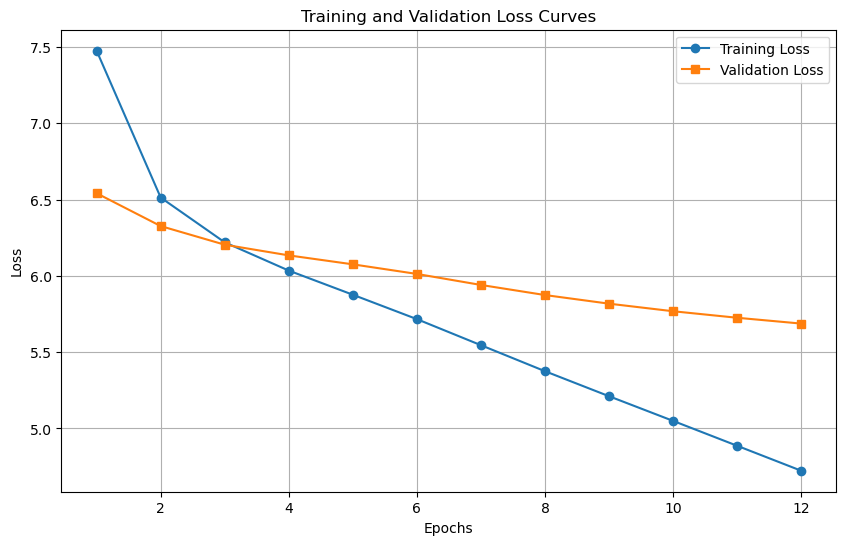

In [14]:
# This code is used to train finalized encoder after hyperparameters are tuned.
# Note that this model training uses whole_train_data and eval_data which are the original train and test split of the 

whole_train_sentences = data.split_based_on_flags(rawdata, train_stories, 0.7, 30, 100)
whole_test_sentences = data.split_based_on_flags(rawdata, test_stories, 0.7, 30, 100)
whole_train_data = data.load_data(whole_train_sentences)
whole_test_data = data.load_data(whole_test_sentences)

model_final = encoder.Encoder(vocab_size = vocab_size, hidden_size = 512, num_heads = 4, 
                            num_layers = 2, intermediate_size = 2048, max_len = 128)

model_trained_final, train_losses_final, val_losses_final = train_encoder.train_bert(model = model_final, 
                                                            train_dataloader=whole_train_data,
                                                            val_dataloader=eval_data,
                                                            tokenizer=tokenizer,
                                                            epochs = 2, lr = 1.2037792108405165e-05, 
                                                            mask_prob = 0.15, device = 'cuda')

In [15]:
# Create embeddings automatically

dict_embed_train = embedding.auto_embeddings(model_trained_final, rawdata, train_stories, max_len = 128, 
                                    tokenizer = None, device = 'cpu', delay = [1, 2, 3, 4])
dict_embed_test = embedding.auto_embeddings(model_trained_final, rawdata, test_stories, max_len = 128, 
                                    tokenizer = None, device = 'cpu', delay = [1, 2, 3, 4])

In [17]:
dict_embed_train["sweetaspie"].shape # The column length should be 256 * 4 = 1024

(157, 2048)

In [18]:
dict_embed_train["sweetaspie"]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.13749742,  1.18537816,  0.09275456, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.57393927,  2.46018948, -1.17234595, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.83822022,  1.64374193, -1.17426381, ..., -2.5433511 ,
         1.85121691,  5.2115885 ],
       [ 0.78665876,  2.13169031, -2.6803815 , ..., -3.21605503,
        -2.62500996,  2.54654285],
       [ 1.12331413,  0.08328985, -3.72231222, ...,  0.57017721,
         0.47617617, -0.66896028]])

In [19]:
print(len(dict_embed_train))
print(len(dict_embed_test))

70
31


In [20]:
import os
import numpy as np
import pandas as pd

def load_measurement_data_by_subject(story_key):
    """Load measurement data and return it separated by subject."""
    base_dir = "../tmp_ondemand_ocean_mth240012p_symlink/shared/data"
    subject2_file = os.path.join(base_dir, "subject2", f"{story_key}.npy")
    subject3_file = os.path.join(base_dir, "subject3", f"{story_key}.npy")
    
    subject2_data = None
    subject3_data = None
    
    if os.path.exists(subject2_file):
        subject2_data = np.load(subject2_file)
        print(f"Loaded subject2 data for '{story_key}'")
    
    if os.path.exists(subject3_file):
        subject3_data = np.load(subject3_file)
        print(f"Loaded subject3 data for '{story_key}'")
    
    return subject2_data, subject3_data

# Load first 6 keys for train and first 2 keys for test
train_keys = list(dict_embed_train.keys())
test_keys = list(dict_embed_test.keys())

# Initialize lists to store data for each subject
subject2_train_rows = []
subject3_train_rows = []
subject2_test_rows = []
subject3_test_rows = []

# Process training data
print("\nProcessing training data:")
for story_key in train_keys:
    subject2_data, subject3_data = load_measurement_data_by_subject(story_key)
    
    if subject2_data is not None:
        subject2_train_rows.append({
            'story_key': story_key,
            'measurement_data': subject2_data
        })
    
    if subject3_data is not None:
        subject3_train_rows.append({
            'story_key': story_key,
            'measurement_data': subject3_data
        })

# Process test data
print("\nProcessing test data:")
for story_key in test_keys:
    subject2_data, subject3_data = load_measurement_data_by_subject(story_key)
    
    if subject2_data is not None:
        subject2_test_rows.append({
            'story_key': story_key,
            'measurement_data': subject2_data
        })
    
    if subject3_data is not None:
        subject3_test_rows.append({
            'story_key': story_key,
            'measurement_data': subject3_data
        })

# Create DataFrames for each subject
train_resp_subject2 = pd.DataFrame(subject2_train_rows).set_index('story_key')
train_resp_subject3 = pd.DataFrame(subject3_train_rows).set_index('story_key')
test_resp_subject2 = pd.DataFrame(subject2_test_rows).set_index('story_key')
test_resp_subject3 = pd.DataFrame(subject3_test_rows).set_index('story_key')

# Print summary
print("\nDataset Summary:")
print(f"Subject 2 training stories: {len(train_resp_subject2)}")
print(f"Subject 3 training stories: {len(train_resp_subject3)}")
print(f"Subject 2 test stories: {len(test_resp_subject2)}")
print(f"Subject 3 test stories: {len(test_resp_subject3)}")

print("\nTraining stories for Subject 2:", list(train_resp_subject2.index))
print("Training stories for Subject 3:", list(train_resp_subject3.index))
print("\nTest stories for Subject 2:", list(test_resp_subject2.index))
print("Test stories for Subject 3:", list(test_resp_subject3.index))

# Print shapes of measurement data
print("\nMeasurement data shapes:")
if len(train_resp_subject2) > 0:
    print(f"Subject 2 training shape: {train_resp_subject2.iloc[0]['measurement_data'].shape}")
if len(train_resp_subject3) > 0:
    print(f"Subject 3 training shape: {train_resp_subject3.iloc[0]['measurement_data'].shape}")


Processing training data:
Loaded subject2 data for 'googlingstrangersandkentuckybluegrass'
Loaded subject3 data for 'googlingstrangersandkentuckybluegrass'
Loaded subject2 data for 'alternateithicatom'
Loaded subject3 data for 'alternateithicatom'
Loaded subject2 data for 'thumbsup'
Loaded subject3 data for 'thumbsup'
Loaded subject2 data for 'igrewupinthewestborobaptistchurch'
Loaded subject3 data for 'igrewupinthewestborobaptistchurch'
Loaded subject2 data for 'penpal'
Loaded subject3 data for 'penpal'
Loaded subject2 data for 'wildwomenanddancingqueens'
Loaded subject3 data for 'wildwomenanddancingqueens'
Loaded subject2 data for 'canplanetearthfeedtenbillionpeoplepart3'
Loaded subject3 data for 'canplanetearthfeedtenbillionpeoplepart3'
Loaded subject2 data for 'souls'
Loaded subject3 data for 'souls'
Loaded subject2 data for 'threemonths'
Loaded subject3 data for 'threemonths'
Loaded subject2 data for 'christmas1940'
Loaded subject3 data for 'christmas1940'
Loaded subject2 data fo


==================== Analyzing subject2 ====================

Evaluating BERT embedding for subject2

Number of stories - Train: 70, Test: 31
Data dimensions:
Training: 24503 timepoints × 2048 features → 94251 voxels
Testing:  10283 timepoints × 2048 features → 94251 voxels

Running cross-validation...
CV mean CC: 0.0087 (±0.0002)

Training final model...

Per-story performance:
Story 1: mean CC = 0.0059 ± 0.0092
Story 2: mean CC = 0.0074 ± 0.0109
Story 3: mean CC = 0.0088 ± 0.0105
Story 4: mean CC = 0.0067 ± 0.0097
Story 5: mean CC = 0.0066 ± 0.0091
Story 6: mean CC = 0.0076 ± 0.0105
Story 7: mean CC = 0.0053 ± 0.0096
Story 8: mean CC = 0.0081 ± 0.0110
Story 9: mean CC = 0.0063 ± 0.0098
Story 10: mean CC = 0.0089 ± 0.0104
Story 11: mean CC = 0.0086 ± 0.0114
Story 12: mean CC = 0.0087 ± 0.0106
Story 13: mean CC = 0.0067 ± 0.0094
Story 14: mean CC = 0.0073 ± 0.0104
Story 15: mean CC = 0.0091 ± 0.0118
Story 16: mean CC = 0.0101 ± 0.0121
Story 17: mean CC = 0.0080 ± 0.0105
Story 18: mean

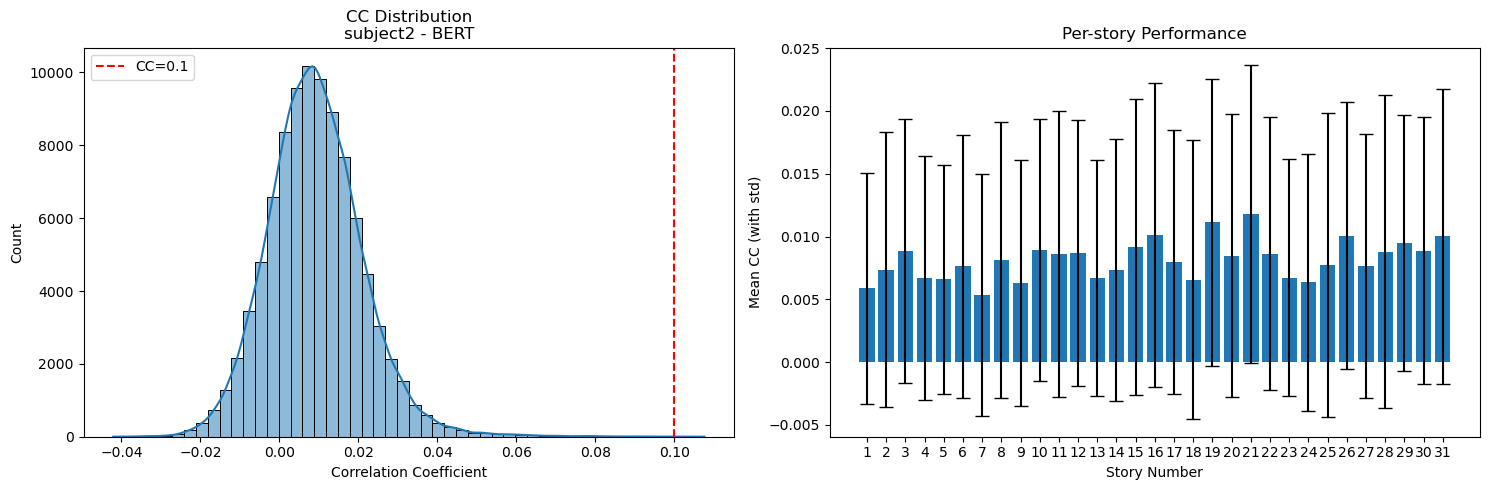


Results Summary:
Mean CC: 0.0092
Median CC: 0.0086
Top 1% CC: 0.0426
Top 5% CC: 0.0293
Voxels with CC > 0.1: 0.0%

==================== Analyzing subject3 ====================

Evaluating BERT embedding for subject3

Number of stories - Train: 70, Test: 31
Data dimensions:
Training: 24503 timepoints × 2048 features → 95556 voxels
Testing:  10283 timepoints × 2048 features → 95556 voxels

Running cross-validation...
CV mean CC: 0.0178 (±0.0012)

Training final model...

Per-story performance:
Story 1: mean CC = 0.0074 ± 0.0108
Story 2: mean CC = 0.0087 ± 0.0121
Story 3: mean CC = 0.0125 ± 0.0151
Story 4: mean CC = 0.0099 ± 0.0104
Story 5: mean CC = 0.0259 ± 0.0202
Story 6: mean CC = 0.0125 ± 0.0141
Story 7: mean CC = 0.0088 ± 0.0094
Story 8: mean CC = 0.0168 ± 0.0163
Story 9: mean CC = 0.0216 ± 0.0187
Story 10: mean CC = 0.0142 ± 0.0158
Story 11: mean CC = 0.0092 ± 0.0101
Story 12: mean CC = 0.0094 ± 0.0115
Story 13: mean CC = 0.0181 ± 0.0162
Story 14: mean CC = 0.0256 ± 0.0220
Story 1

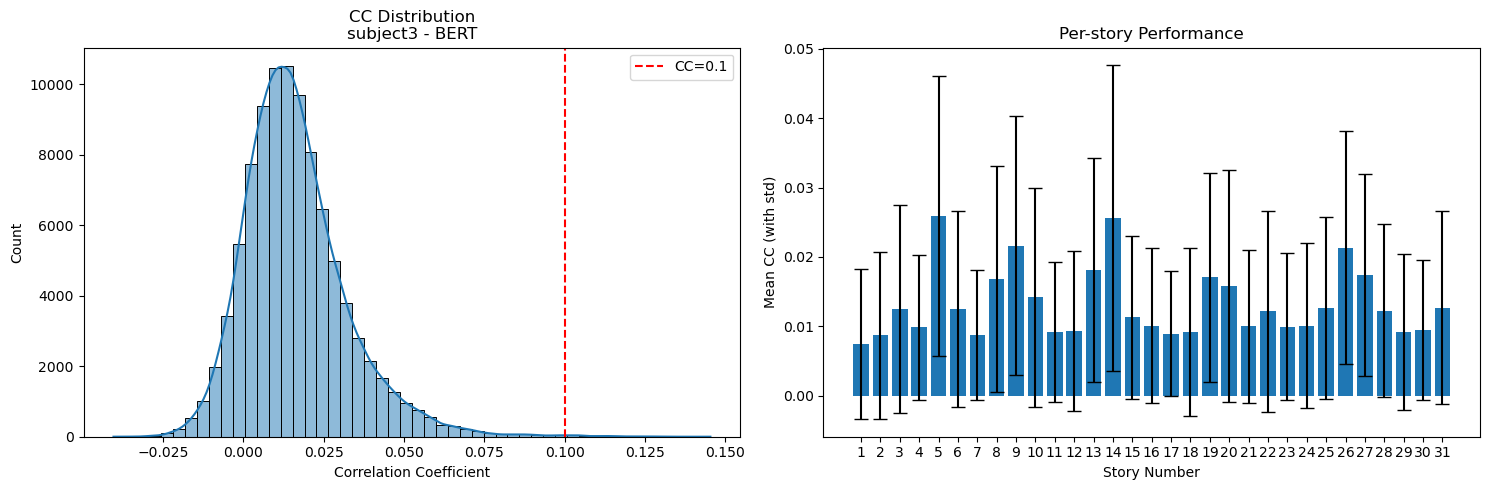


Results Summary:
Mean CC: 0.0163
Median CC: 0.0143
Top 1% CC: 0.0669
Top 5% CC: 0.0460
Voxels with CC > 0.1: 0.2%

=== Final Cross-subject Comparison ===

BERT:
subject2:
  Mean CC: 0.0092
  Voxels > 0.1: 0.0%
subject3:
  Mean CC: 0.0163
  Voxels > 0.1: 0.2%


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ridge_utils.ridge import bootstrap_ridge, ridge_corr, ridge_corr_pred, zs
import pickle
import os

# Create results directory
os.makedirs('../results', exist_ok=True)

# Create figs directory
os.makedirs('../figs', exist_ok=True)

# Constants
ALPHAS = np.logspace(1, 3, 3)  # [10, 100, 1000]
NBOOTS = 3
CHUNKLEN = 10
CC_THRESHOLD = 0.1  # Updated threshold from 0.2 to 0.1

def evaluate_embedding(train_embed, test_embed, train_resp, test_resp, embed_name, subject_name):
    """Efficient evaluation with focused output."""
    print(f"\n{'='*50}")
    print(f"Evaluating {embed_name} embedding for {subject_name}")
    
    # Data preparation
    train_keys = sorted(set(train_embed.keys()) & set(train_resp.index))
    test_keys = sorted(set(test_embed.keys()) & set(test_resp.index))
    
    print(f"\nNumber of stories - Train: {len(train_keys)}, Test: {len(test_keys)}")
    
    X_train_list, y_train_list = [], []
    X_test_dict, y_test_dict = {}, {}
    
    # Prepare training data
    for key in train_keys:
        embed = train_embed[key]
        resp = train_resp.loc[key, 'measurement_data']
        min_len = min(embed.shape[0], resp.shape[0])
        X_train_list.append(embed[:min_len])
        y_train_list.append(resp[:min_len])
    
    # Prepare test data
    for key in test_keys:
        embed = test_embed[key]
        resp = test_resp.loc[key, 'measurement_data']
        min_len = min(embed.shape[0], resp.shape[0])
        X_test_dict[key] = embed[:min_len]
        y_test_dict[key] = resp[:min_len]
    
    X_train = np.vstack(X_train_list)
    y_train = np.vstack(y_train_list)
    X_test = np.vstack(list(X_test_dict.values()))
    y_test = np.vstack(list(y_test_dict.values()))
    
    print(f"Data dimensions:")
    print(f"Training: {X_train.shape[0]} timepoints × {X_train.shape[1]} features → {y_train.shape[1]} voxels")
    print(f"Testing:  {X_test.shape[0]} timepoints × {X_test.shape[1]} features → {y_test.shape[1]} voxels")
    
    # Cross-validation
    n_splits = 3
    chunk_size = len(X_train) // n_splits
    cv_scores = []
    
    print("\nRunning cross-validation...")
    for i in range(n_splits):
        val_start = i * chunk_size
        val_end = (i + 1) * chunk_size
        
        X_val = X_train[val_start:val_end]
        y_val = y_train[val_start:val_end]
        X_train_cv = np.vstack([X_train[:val_start], X_train[val_end:]])
        y_train_cv = np.vstack([y_train[:val_start], y_train[val_end:]])
        
        wt_cv, corrs_cv, _, _, _ = bootstrap_ridge(
            X_train_cv, y_train_cv, X_val, y_val,
            alphas=ALPHAS, nboots=NBOOTS, chunklen=CHUNKLEN,
            nchunks=3, corrmin=CC_THRESHOLD, normalpha=True
        )
        cv_scores.append(np.mean(corrs_cv))
    
    print(f"CV mean CC: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")
    
    # Final model training
    print("\nTraining final model...")
    wt, corrs, valphas, allRcorrs, _ = bootstrap_ridge(
        X_train, y_train, X_test, y_test,
        alphas=ALPHAS, nboots=NBOOTS, chunklen=CHUNKLEN,
        nchunks=3, corrmin=CC_THRESHOLD, normalpha=True
    )
    
    # Per-story analysis
    story_performances = {}
    story_boundaries = np.cumsum([0] + [len(X_test_dict[k]) for k in test_keys])
    
    print("\nPer-story performance:")
    for i, key in enumerate(test_keys):
        story_corrs = corrs[story_boundaries[i]:story_boundaries[i+1]]
        story_performances[key] = {
            'mean_cc': np.nanmean(story_corrs),
            'median_cc': np.nanmedian(story_corrs),
            'std_cc': np.nanstd(story_corrs),
            'n_voxels': len(story_corrs),
            'correlations': story_corrs
        }
        print(f"Story {i+1}: mean CC = {story_performances[key]['mean_cc']:.4f} ± {story_performances[key]['std_cc']:.4f}")
    
    # Compute metrics
    metrics = {
        'mean_cc': np.nanmean(corrs),
        'median_cc': np.nanmedian(corrs),
        'top_1_percentile': np.nanpercentile(corrs, 99),
        'top_5_percentile': np.nanpercentile(corrs, 95),
        'correlations': corrs,
        'cv_scores': cv_scores,
        'story_performances': story_performances,
        'voxels_above_threshold': np.mean(corrs > CC_THRESHOLD) * 100
    }
    
    # Save model
    model_data = {
        'weights': wt,
        'best_alphas': valphas,
        'metrics': metrics,
        'training_shapes': {'X': X_train.shape, 'y': y_train.shape}
    }
    
    with open(f'../results/ridge_model_{subject_name}_{embed_name}.pkl', 'wb') as f:
        pickle.dump(model_data, f)
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # CC Distribution
    sns.histplot(corrs[~np.isnan(corrs)], bins=50, kde=True, ax=ax1)
    ax1.axvline(x=CC_THRESHOLD, color='r', linestyle='--', label=f'CC={CC_THRESHOLD}')
    ax1.set_title(f'CC Distribution\n{subject_name} - {embed_name}')
    ax1.set_xlabel('Correlation Coefficient')
    ax1.legend()
    
    # Story Performance with numerical indices
    story_means = [perf['mean_cc'] for perf in story_performances.values()]
    story_stds = [perf['std_cc'] for perf in story_performances.values()]
    x_pos = np.arange(1, len(story_means) + 1)
    
    ax2.bar(x_pos, story_means, yerr=story_stds, capsize=5)
    ax2.set_title('Per-story Performance')
    ax2.set_xlabel('Story Number')
    ax2.set_ylabel('Mean CC (with std)')
    ax2.set_xticks(x_pos)
    
    plt.tight_layout()
    
    # Save figure as PNG in ../figs directory
    fig.savefig(os.path.join('../figs', f"{subject_name}_{embed_name}.png"), dpi=300)
    
    # Display figure
    plt.show()
    
    # Print final results
    print("\nResults Summary:")
    print(f"Mean CC: {metrics['mean_cc']:.4f}")
    print(f"Median CC: {metrics['median_cc']:.4f}")
    print(f"Top 1% CC: {metrics['top_1_percentile']:.4f}")
    print(f"Top 5% CC: {metrics['top_5_percentile']:.4f}")
    print(f"Voxels with CC > {CC_THRESHOLD}: {metrics['voxels_above_threshold']:.1f}%")
    
    return metrics

# Main execution
subjects_to_analyze = {
    'subject2': (train_resp_subject2, test_resp_subject2),
    'subject3': (train_resp_subject3, test_resp_subject3)
}

embedding_pairs = {
    'BERT': (dict_embed_train, dict_embed_test)
}

# Run analysis
all_results = {}
for subject_name, (train_resp, test_resp) in subjects_to_analyze.items():
    print(f"\n{'='*20} Analyzing {subject_name} {'='*20}")
    
    subject_results = {}
    for embed_name, (train_embed, test_embed) in embedding_pairs.items():
        subject_results[embed_name] = evaluate_embedding(
            train_embed, test_embed,
            train_resp, test_resp,
            embed_name, subject_name
        )
    
    all_results[subject_name] = subject_results

# Final cross-subject comparison
print("\n=== Final Cross-subject Comparison ===")
for embed_name in embedding_pairs:
    print(f"\n{embed_name}:")
    for subject_name in subjects_to_analyze:
        metrics = all_results[subject_name][embed_name]
        print(f"{subject_name}:")
        print(f"  Mean CC: {metrics['mean_cc']:.4f}")
        print(f"  Voxels > {CC_THRESHOLD}: {metrics['voxels_above_threshold']:.1f}%")